In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Sun Jun 12 19:44:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   39C    P8    21W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 29%   

# MongoDB

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_de = db.patent_de
    # db_us = db.patent_us
    # db_cn = db.patent_cn

    db_rm_cn_2011 = db.rm_patent_cn_2011
    db_rm_us_2011 = db.rm_patent_us_2011
    db_rm_de_2011 = db.rm_patent_de_2011

    
except errors.ConnectionFailure as err:
    print(err)

# 2011

## Company數量

In [6]:
data_assignee = db_rm_de_2011.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])

In [7]:
df_family_de = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [8]:
data_assignee = db_rm_cn_2011.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [9]:
data_assignee = db_rm_us_2011.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [10]:
final_df = pd.concat([df_family_de,df_family_cn,df_family_us],axis=0)

In [11]:
# 取總數前15家公司
final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
26,"Jinhu Zhongbo IOT Technology Co., Ltd.",30
24,Jiangsu IoT Research and Development Center,17
39,Qualcomm Inc,14
54,Xerox Corp,13
28,LG Electronics Inc,10
57,ZTE Corp,9
15,"Gaoxing Zhilian Technology Co., Ltd.",9
43,Samsung Electronics Co Ltd,7
9,China core Microelectronics Technology Chengdu...,7
11,Datang Mobile Communications Equipment Co Ltd,6


In [33]:
com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(18)
com_df.reset_index(drop=True, inplace=True)

In [34]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))
com_df

,company,count,count_log
0,"Jinhu Zhongbo IOT Technology Co., Ltd.",30,3.401197
1,Jiangsu IoT Research and Development Center,17,2.833213
2,Qualcomm Inc,14,2.639057
3,Xerox Corp,13,2.564949
4,LG Electronics Inc,10,2.302585
5,ZTE Corp,9,2.197225
6,"Gaoxing Zhilian Technology Co., Ltd.",9,2.197225
7,Samsung Electronics Co Ltd,7,1.945910
8,China core Microelectronics Technology Chengdu...,7,1.945910
9,Datang Mobile Communications Equipment Co Ltd,6,1.791759


In [35]:
com_ls = list(com_df.company)

## Data

In [36]:
ccontry = pd.read_csv("./final_data/rm_company_country_all_2011.csv")
ccpc = pd.read_csv("./final_data/rm_company_cpc_all_2011.csv")

In [37]:
ccontry[ccontry.company.isin(com_ls)].head()

,company,AP,AR,AU,BR,CA,CL,CN,CO,CR,...,RU,SG,SI,SM,TR,TW,UA,US,UY,ZA
52,Canon Inc,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0
58,Chengdu Qinchuan IoT Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,China core Microelectronics Technology Chengdu...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90,Datang Mobile Communications Equipment Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112,Fujifilm Business Innovation Corp,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0


## Similarity計算

### Country

- 換成機率  

In [38]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

### PBC
- 和Samsung Electronics Co Ltd比較

In [39]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc.head()

,AP,AR,AU,BR,CA,CL,CN,CO,CR,CU,...,RU,SG,SI,SM,TR,TW,UA,US,UY,ZA
company,,,,,,,,,,,,,,,,,,,,,
"Jinhu Zhongbo IOT Technology Co., Ltd.",0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
Jiangsu IoT Research and Development Center,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
Qualcomm Inc,0.0,0.0,0.0,0.011765,0.0,0.0,0.176471,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.094118,0.0,0.188235,0.0,0.0
Xerox Corp,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.928571,0.0,0.0
LG Electronics Inc,0.0,0.0,0.0,0.000000,0.0,0.0,0.142857,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.571429,0.0,0.0


In [40]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### CPC

In [41]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [42]:
# ccpc_pbc = ccpc2.loc[com_ls,:].copy()
ccpc_pbc = ccpc2[ccpc2.index.isin(com_ls)]
# ccpc_pbc

In [43]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

## Scatter Plot

In [44]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

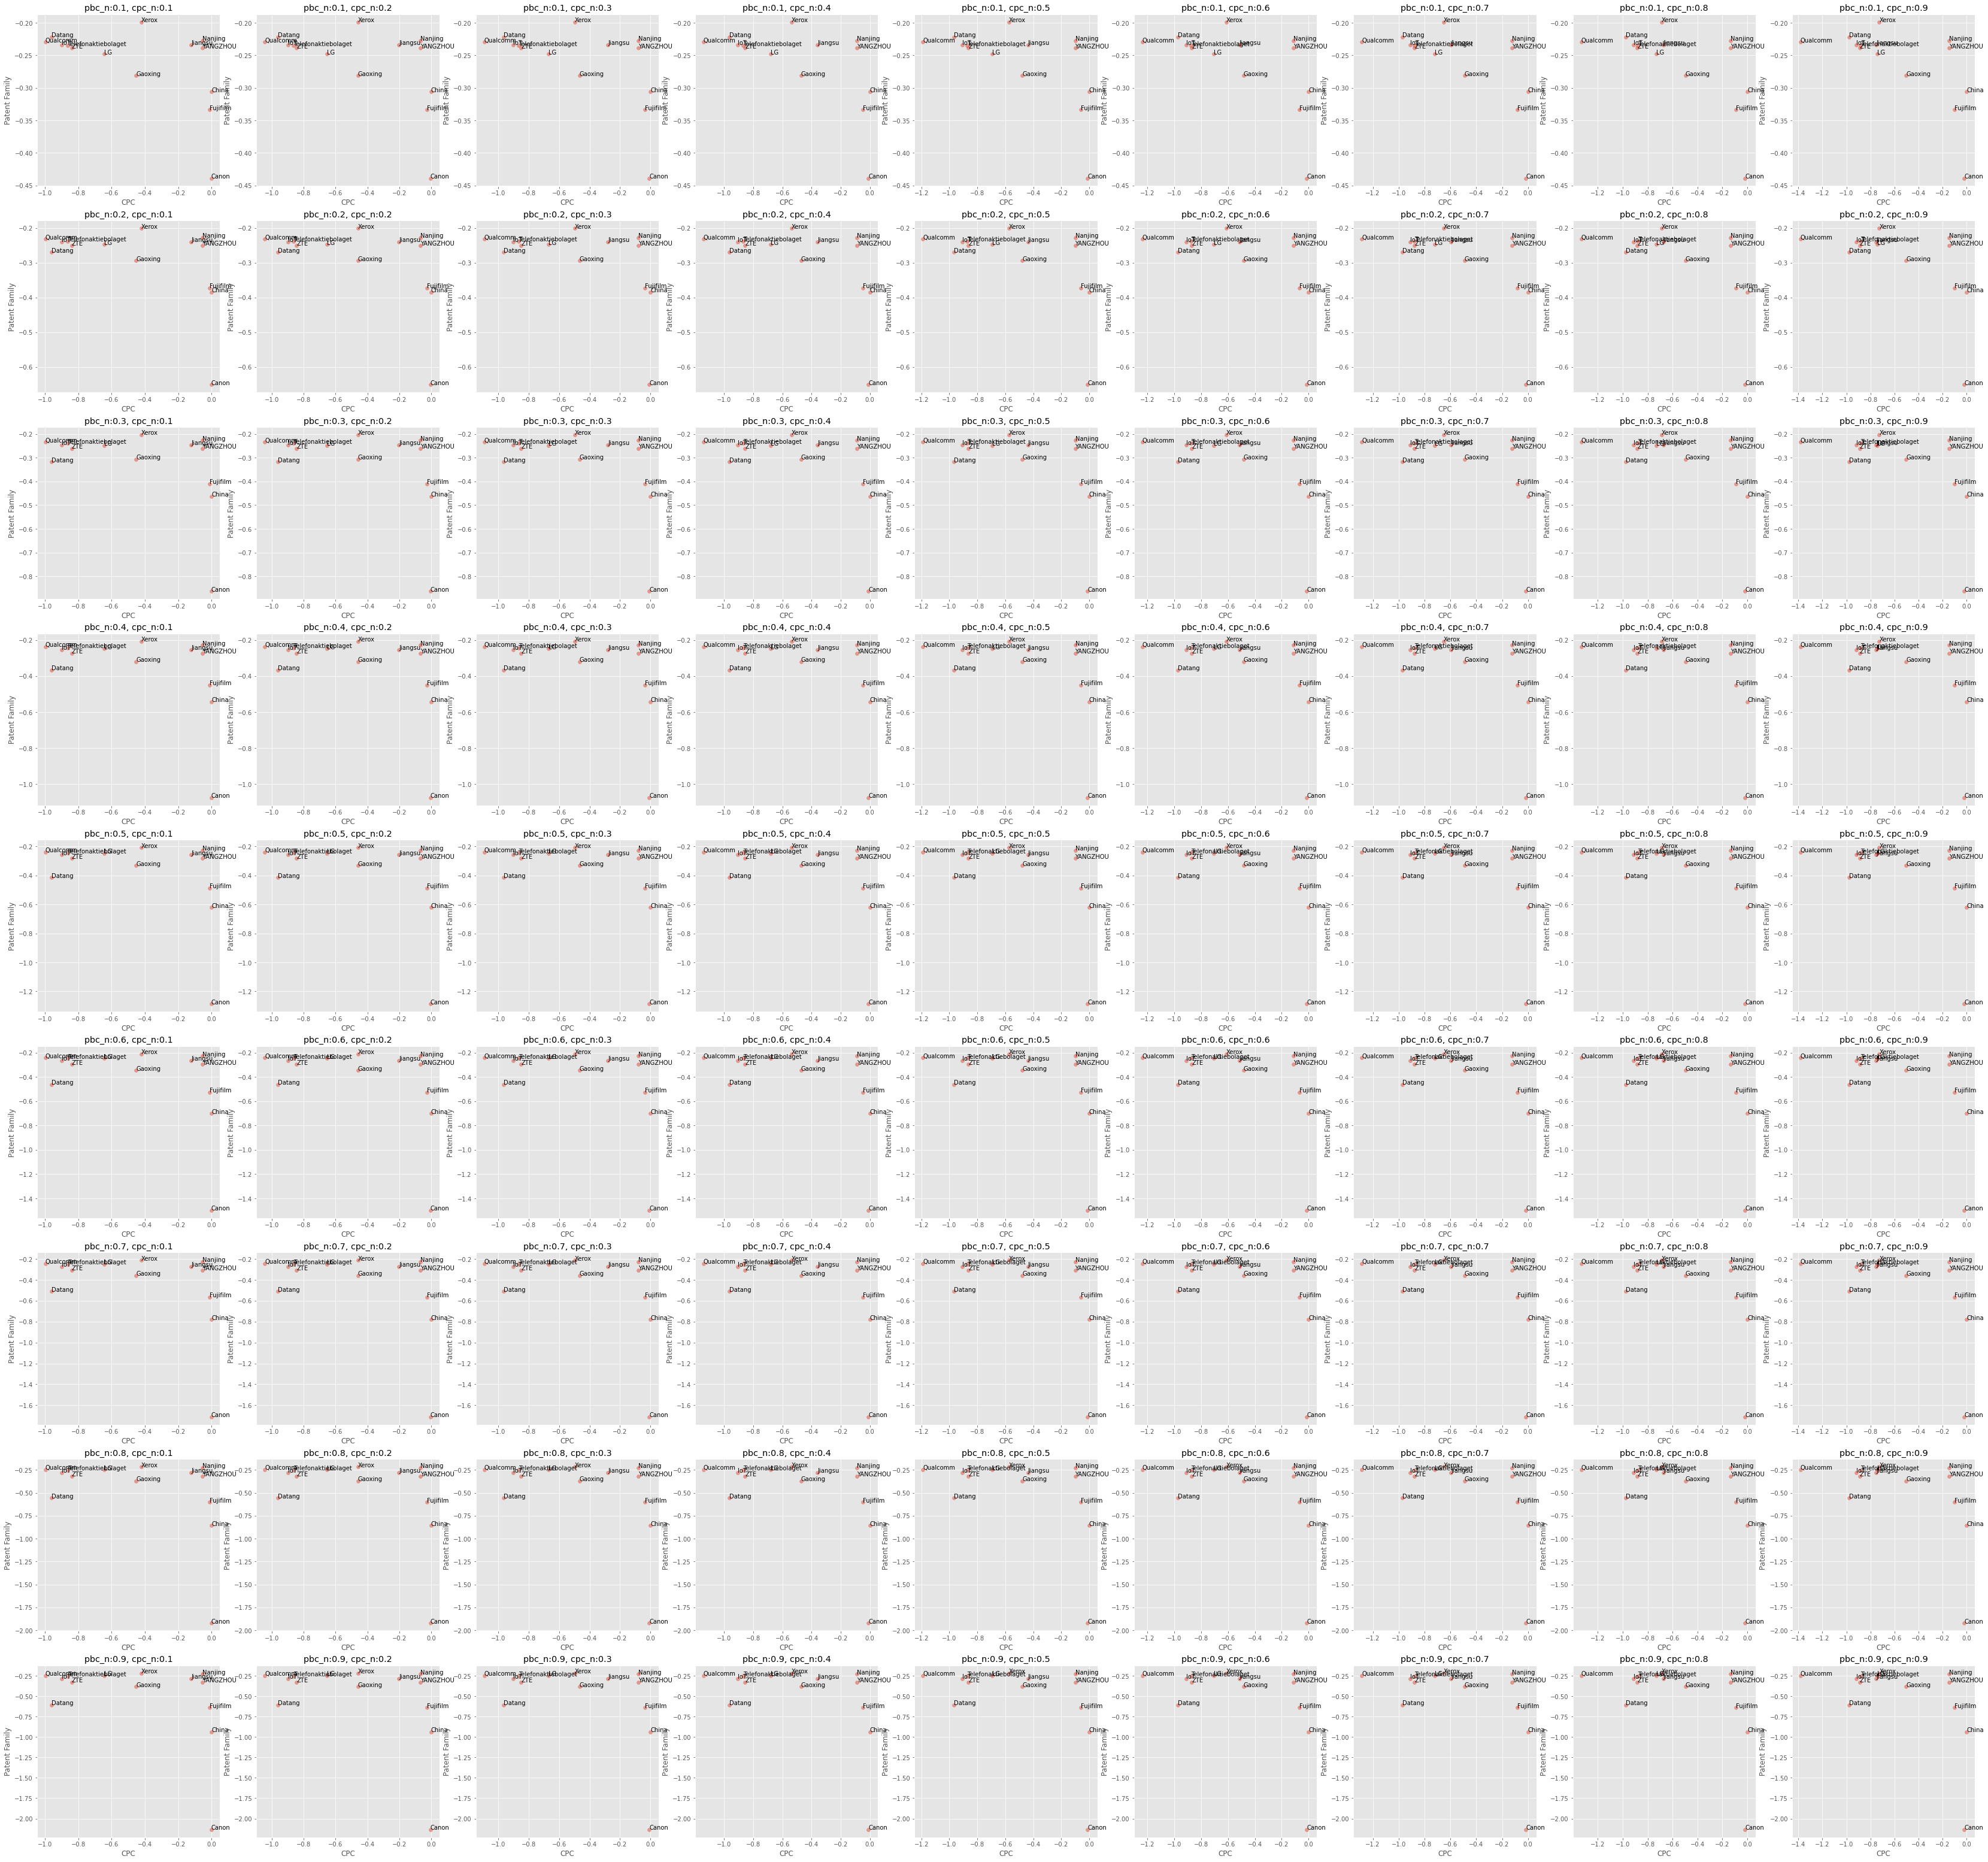

In [45]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2011_1.png'.format(pbc_n))

In [46]:
c_df

,cpc,country
company,,
Canon Inc,0.021386,2.133348
"China core Microelectronics Technology Chengdu Co.,Ltd.",0.000000,0.935849
Datang Mobile Communications Equipment Co Ltd,0.977908,0.606205
Fujifilm Business Innovation Corp,0.103391,0.640343
"Gaoxing Zhilian Technology Co., Ltd.",0.503220,0.382894
IoT Holdings Inc,0.917038,0.284116
Jiangsu IoT Research and Development Center,0.752055,0.284116
LG Electronics Inc,0.744400,0.247934
Nanjing IoT Sensor Technology Co Ltd,0.145370,0.227273


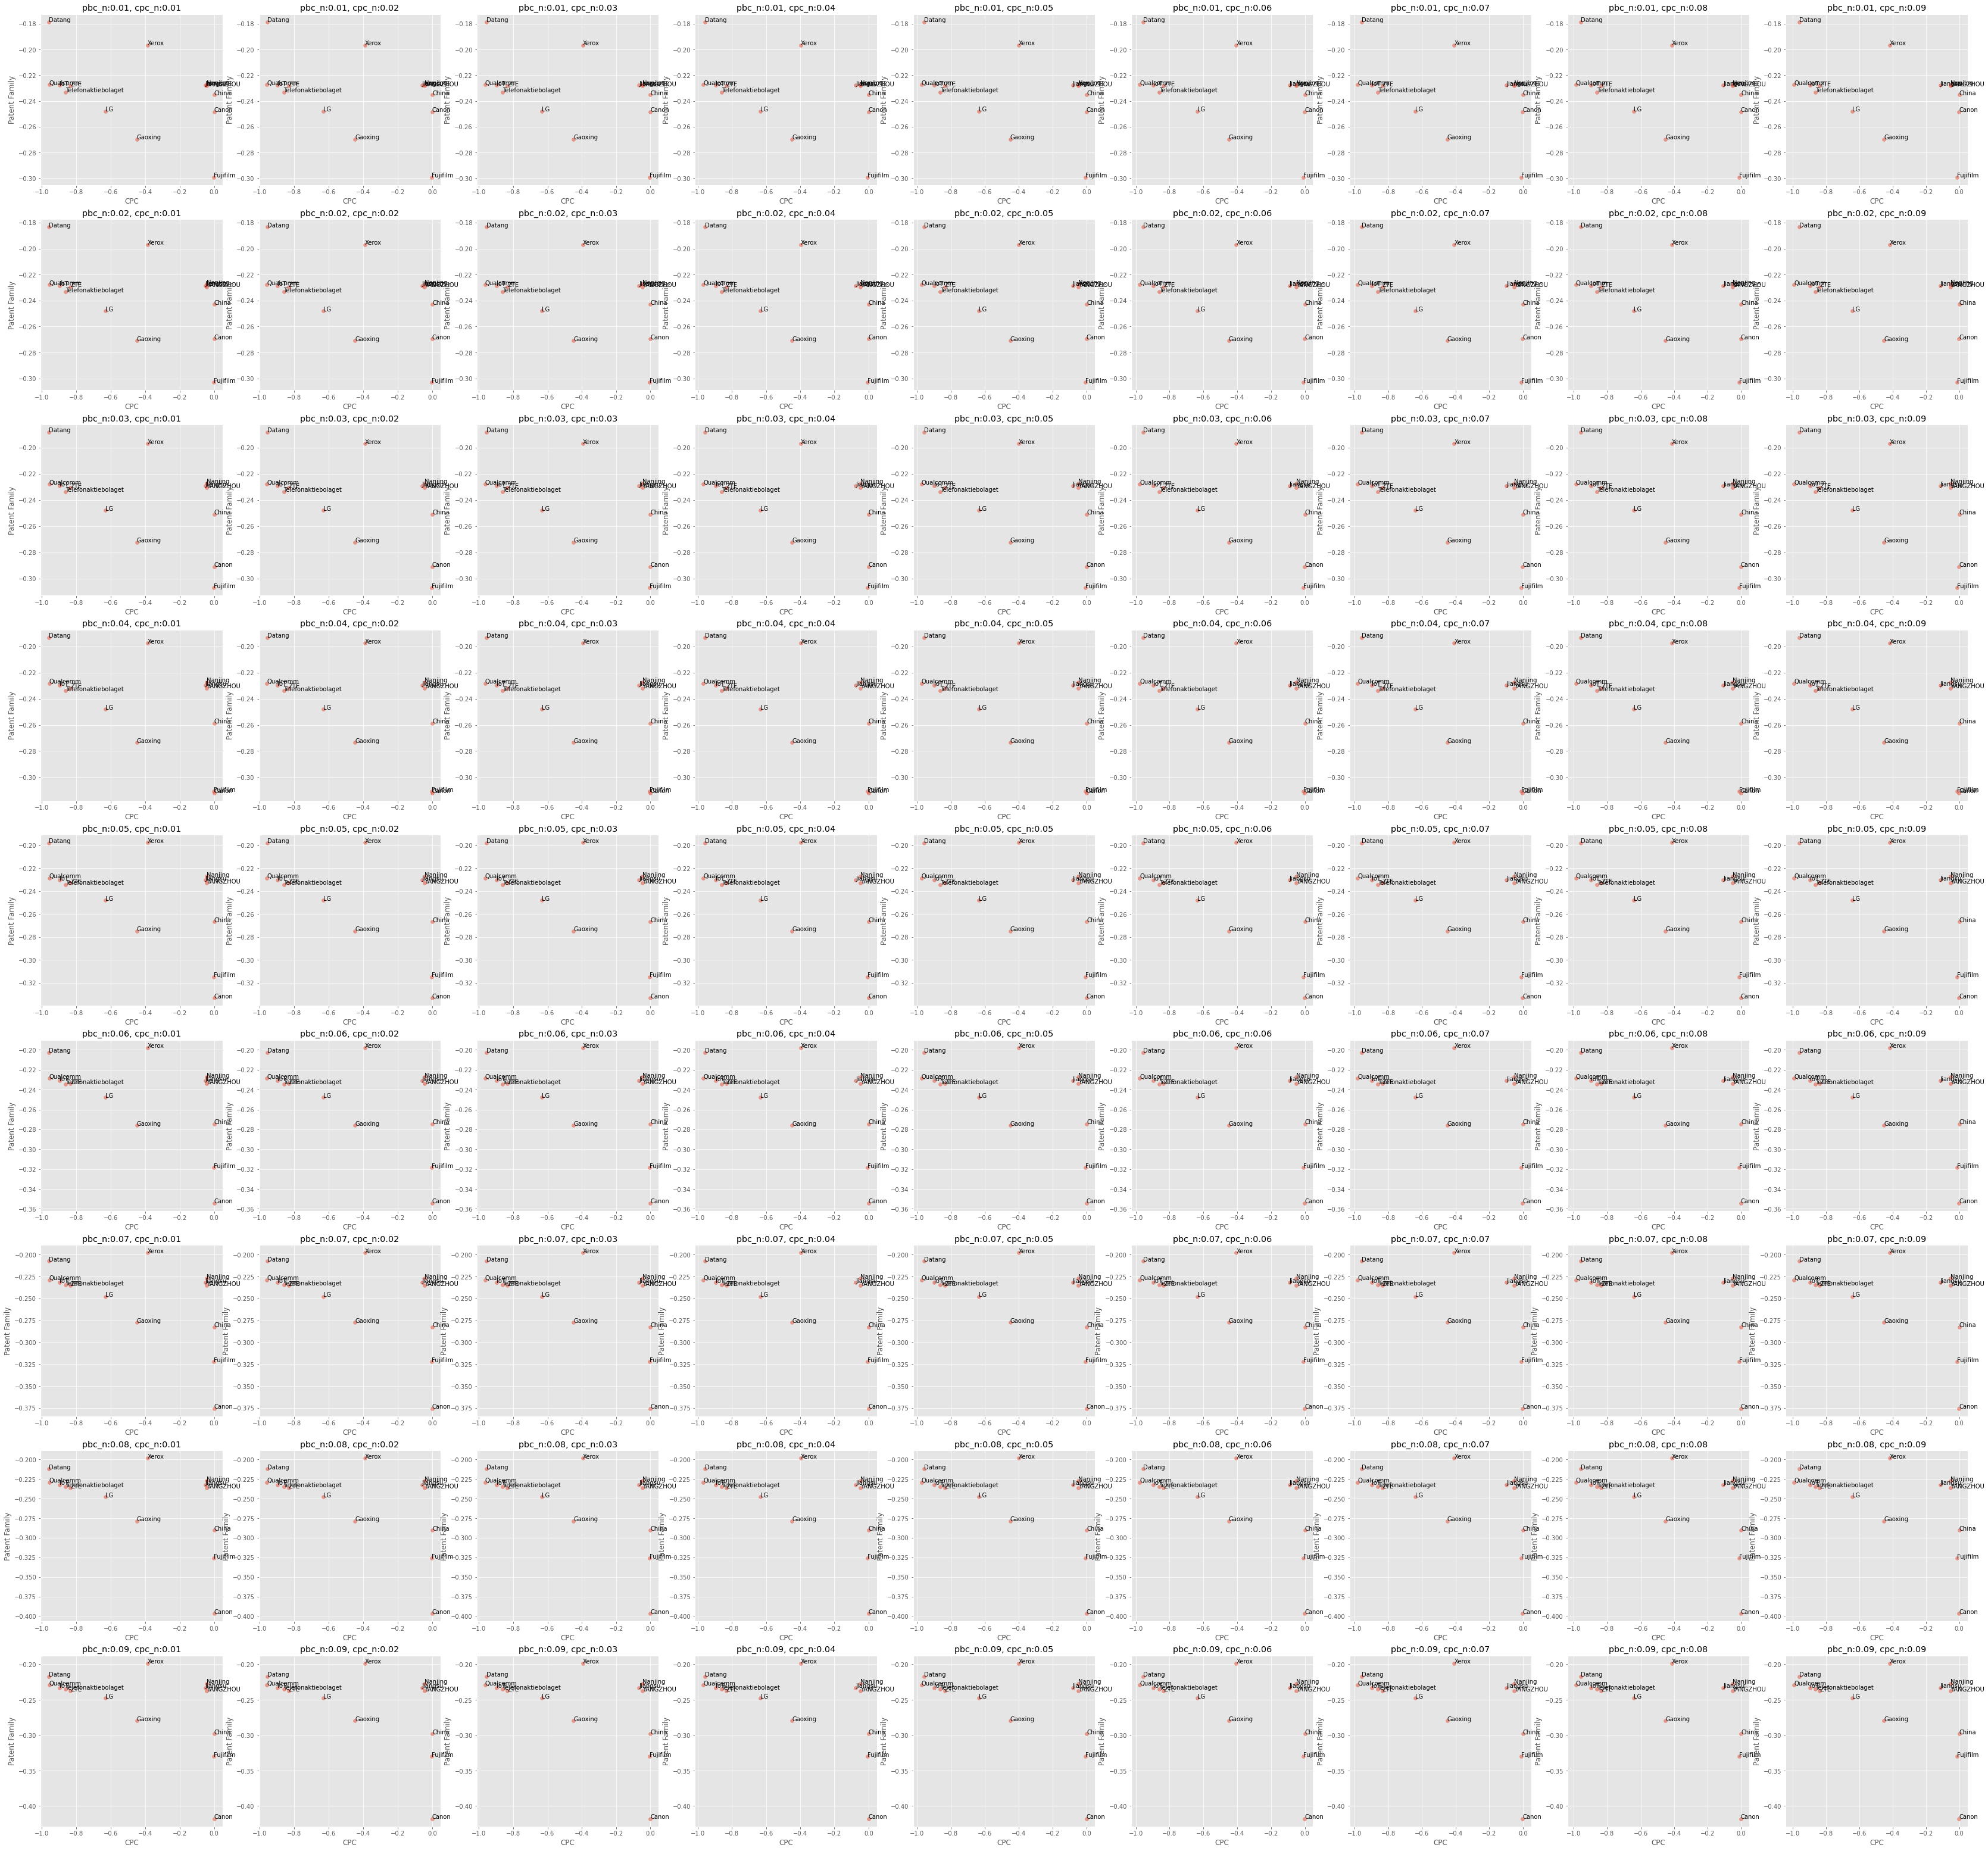

In [47]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2011_2.png'.format(pbc_n))

In [48]:
c_df

,cpc,country
company,,
Canon Inc,0.002139,0.417880
"China core Microelectronics Technology Chengdu Co.,Ltd.",0.000000,0.298130
Datang Mobile Communications Equipment Co Ltd,0.958660,0.217038
Fujifilm Business Innovation Corp,0.011688,0.329943
"Gaoxing Zhilian Technology Co., Ltd.",0.452061,0.279848
IoT Holdings Inc,0.897791,0.232957
Jiangsu IoT Research and Development Center,0.114336,0.232957
LG Electronics Inc,0.641354,0.247934
Nanjing IoT Sensor Technology Co Ltd,0.053667,0.227273


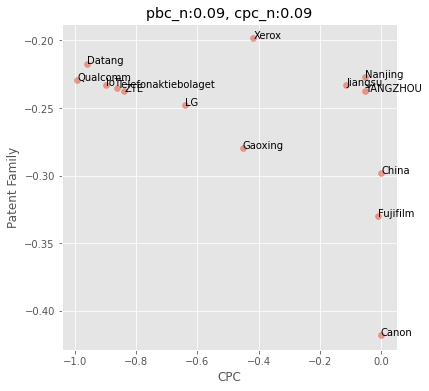

In [49]:
plt.figure(figsize=(6,6))
plt.style.use('ggplot')
c_df = scatter_plot(0.09,0.09)
c_df = c_df.drop("Samsung Electronics Co Ltd")

#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [50]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [51]:
competitor_ls

[3, 1, 2, 3, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2]

In [52]:
list(c_df.index)

['Canon Inc',
 'China core Microelectronics Technology Chengdu Co.,Ltd.',
 'Datang Mobile Communications Equipment Co Ltd',
 'Fujifilm Business Innovation Corp',
 'Gaoxing Zhilian Technology Co., Ltd.',
 'IoT Holdings Inc',
 'Jiangsu IoT Research and Development Center',
 'LG Electronics Inc',
 'Nanjing IoT Sensor Technology Co Ltd',
 'Qualcomm Inc',
 'Telefonaktiebolaget LM Ericsson AB',
 'Xerox Corp',
 "YANGZHOU SU'AN IOT SENSING TECHNOLOGY Co Ltd",
 'ZTE Corp']